# Convolutional Neural Network (CNNs) in PyTorch

In [20]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image

from torchvision import transforms

In [21]:
device = torch.device("cuda:0")

## Data loading

In [22]:
# First, lets load the dataset
data_train = dset.SVHN('./data', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))
print(data_test)

Dataset SVHN
    Number of datapoints: 26032
    Root location: ./data
    Split: test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.43, 0.44, 0.47], std=[0.2, 0.2, 0.2])
           )


## We divide the data into training and validation.


In [23]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [24]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

## Data augmentation

In [32]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./data', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, sampler=train_sampler)

## Augmented image visualization

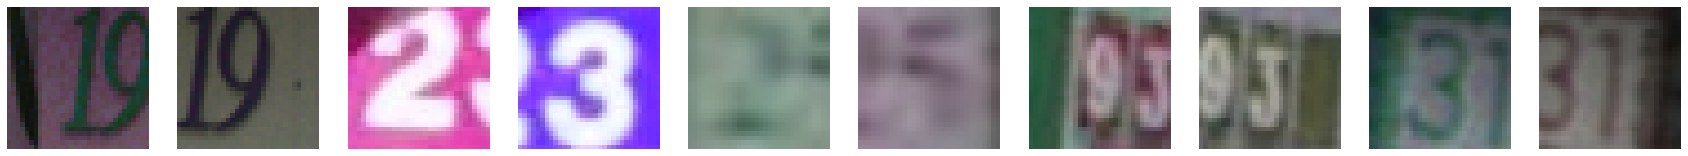

In [33]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
])

data_aug_vis = dset.SVHN('./data', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

## Training function and accuracy calculation function

In [26]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        
        prediction = model(x_gpu)
        
        optimizer.zero_grad()
        optimizer.step()
        
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y_gpu.shape[0]
        
    v_accuracy = float(correct_samples) / total_samples
        
    return v_accuracy

## Model creation

In [27]:
best_model = nn.Sequential(
    nn.Conv2d(3, 16, 5),
    nn.BatchNorm2d(16),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(16, 32, 5),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, stride=2),   
    nn.Conv2d(32, 64, 5),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Dropout2d(p=0.2),
    Flattener(),
    nn.Linear(64, 64),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.2),
    nn.Linear(64, 10)
          )

for module in best_model.parameters():
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(module.weight, gain=nn.init.calculate_gain('relu'))

    
best_model.type(torch.cuda.FloatTensor)
best_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(best_model.parameters(), lr=0.001, weight_decay=1e-05)
loss_history, train_history, val_history = train_model(best_model, train_aug_loader, val_loader, loss, optimizer, 50)

Average loss: 0.842263, Train accuracy: 0.733747, Val accuracy: 0.819808
Average loss: 0.509077, Train accuracy: 0.844419, Val accuracy: 0.879530
Average loss: 0.445779, Train accuracy: 0.866089, Val accuracy: 0.858235
Average loss: 0.406530, Train accuracy: 0.876207, Val accuracy: 0.839874
Average loss: 0.385564, Train accuracy: 0.883783, Val accuracy: 0.884035
Average loss: 0.364960, Train accuracy: 0.890028, Val accuracy: 0.884513
Average loss: 0.346458, Train accuracy: 0.896035, Val accuracy: 0.890315
Average loss: 0.331606, Train accuracy: 0.899618, Val accuracy: 0.886492
Average loss: 0.317733, Train accuracy: 0.904225, Val accuracy: 0.893386
Average loss: 0.308151, Train accuracy: 0.907655, Val accuracy: 0.902805
Average loss: 0.298321, Train accuracy: 0.909804, Val accuracy: 0.888813
Average loss: 0.287889, Train accuracy: 0.912108, Val accuracy: 0.907788
Average loss: 0.280994, Train accuracy: 0.915350, Val accuracy: 0.904853
Average loss: 0.271950, Train accuracy: 0.916425, V

## Final test accuracy

In [28]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
final_test_accuracy = compute_accuracy(best_model, test_loader)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.9035802089735709
